# SWB Regression Pipeline - Beta Power 
Created: 07/30/24 \
Updated: 08/19/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08192024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [7]:
beta_df = pd.read_csv(f'{save_dir}beta_master_df.csv')
beta_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [12]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

# # keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
# #     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# # keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
# # keep_rois


In [13]:
# ####### NEW DATA FRAME 
# beta_reg_df = beta_df.copy()
# beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(keep_rois)]
# len(beta_reg_df)

# Test Single Electrode Regressions 

In [11]:
elec_col    = 'unique_reref_ch'
main_var    = 'decisionCPE'
reg_formula = 'band_pow~GambleChoice+TotalProfit+decisionCPE'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(beta_df,reg_formula,elec_col, main_var,n_permutations)

Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4056.56it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4076.03it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4183.81it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4087.55it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4400.41it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4088.02it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4066.94it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4115.47it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3969.94it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4078.49it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4009.53it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4039.07it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4059.26it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4001.52it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4090.88it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 4116.12it/s]


In [12]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'decisionCPE']

In [13]:
results = single_elec_permutation_results(results_dict,beta_df,save_vars)
results

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.030883,-0.048833,0.024836,0.030278,-0.002225,-0.000975,...,0.021605,0.022110,2.017426,-2.017426,1.155243,1.344197,0.043651,0.043651,0.247991,0.178885
1,MS002_lacas2-lacas3,MS002,acc,14,-0.010171,0.017089,0.019667,0.041767,0.001676,-0.000036,...,0.026959,0.025136,-0.610713,0.610713,0.724511,1.674859,0.541390,0.541390,0.468752,0.093962
2,MS002_lacas3-lacas4,MS002,acc,14,0.010854,-0.016153,0.012513,0.045390,-0.000735,0.000600,...,0.023052,0.023218,0.638730,-0.638730,0.530250,1.944106,0.522999,0.522999,0.595939,0.051883
3,MS002_lacas4-lacas5,MS002,acc,14,0.002168,-0.016207,-0.007460,0.041141,-0.009189,0.000210,...,0.021055,0.020767,0.719456,-0.719456,-0.334509,1.970064,0.471860,0.471860,0.737996,0.048831
4,MS002_lacas5-lacas6,MS002,acc,14,-0.008841,0.017567,-0.006853,-0.003911,0.002637,0.000975,...,0.022006,0.021010,-0.686458,0.686458,-0.319261,-0.188495,0.492424,0.492424,0.749528,0.850489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875,DA039_rtp6-rtp7,DA039,temporal pole,22,-0.103029,0.057086,-0.034122,0.012203,-0.081526,0.000992,...,0.030634,0.030313,-1.857189,1.857189,-1.146275,0.409053,0.063284,0.063284,0.251681,0.682501
1876,DA039_rtp7-rtp8,DA039,temporal pole,22,-0.124557,-0.010397,0.019071,-0.013483,-0.128965,0.001102,...,0.028079,0.028616,0.413141,-0.413141,0.687641,-0.414588,0.679503,0.679503,0.491679,0.678444
1877,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.123066,0.017559,0.011615,0.056642,-0.116101,-0.000610,...,0.047269,0.046641,-0.393639,0.393639,0.226441,1.191610,0.693848,0.693848,0.820858,0.233414
1878,DA039_rsgcc7-rsgcc8,DA039,vlpfc,22,-0.070905,0.005338,-0.014417,0.112998,-0.069551,0.001806,...,0.050501,0.048799,-0.075493,0.075493,-0.271300,2.269159,0.939823,0.939823,0.786160,0.023259


In [14]:
results.columns

Index(['unique_elec_id', 'subj_id', 'roi', 'bdi',
       'Original_Estimate_Intercept', 'Original_Estimate_GambleChoice[T.safe]',
       'Original_Estimate_TotalProfit', 'Original_Estimate_decisionCPE',
       'Permuted_Mean_Intercept', 'Permuted_Mean_GambleChoice[T.safe]',
       'Permuted_Mean_TotalProfit', 'Permuted_Mean_decisionCPE',
       'Permuted_Std_Intercept', 'Permuted_Std_GambleChoice[T.safe]',
       'Permuted_Std_TotalProfit', 'Permuted_Std_decisionCPE',
       'Z_Score_Intercept', 'Z_Score_GambleChoice[T.safe]',
       'Z_Score_TotalProfit', 'Z_Score_decisionCPE', 'P_Value_Intercept',
       'P_Value_GambleChoice[T.safe]', 'P_Value_TotalProfit',
       'P_Value_decisionCPE'],
      dtype='object')

In [15]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_beta_{reg_formula}_{date}.pkl',"wb"))

In [16]:
sig_data = results[results.unique_elec_id.isin(main_var_sig)]
sig_data

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
3,MS002_lacas4-lacas5,MS002,acc,14,0.002168,-0.016207,-0.007460,0.041141,-0.009189,0.000210,...,0.021055,0.020767,0.719456,-0.719456,-0.334509,1.970064,0.471860,0.471860,0.737996,0.048831
18,MS002_laims4-laims5,MS002,ains,14,-0.007378,0.047009,0.043292,0.065644,0.025625,-0.000698,...,0.030240,0.029493,-1.431510,1.431510,1.383910,2.246489,0.152284,0.152284,0.166386,0.024673
30,MS002_lhplt9-lhplt10,MS002,sts,14,-0.084193,0.043151,0.057495,-0.065737,-0.054200,-0.000206,...,0.025819,0.026788,-1.529711,1.529711,2.273048,-2.440962,0.126088,0.126088,0.023023,0.014648
62,MS002_racas7-racas8,MS002,dmpfc,14,0.128225,-0.127799,0.014455,-0.067314,0.039242,0.000830,...,0.032381,0.032435,3.774232,-3.774232,0.367119,-2.067865,0.000161,0.000161,0.713530,0.038653
72,MS002_raims1-raims2,MS002,ains,14,0.112480,-0.115058,0.034586,0.097877,0.032418,0.000676,...,0.039220,0.039375,2.713466,-2.713466,0.916408,2.492442,0.006658,0.006658,0.359453,0.012687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1803,DA037_rmins1-rmins2,DA037,pins,4,-0.134143,0.055278,-0.020561,0.089573,-0.120894,-0.001030,...,0.028219,0.027749,-1.677036,1.677036,-0.716964,3.188111,0.093535,0.093535,0.473396,0.001432
1849,DA039_rpmot4-rpmot5,DA039,motor,22,-0.067399,0.050385,0.078804,-0.072395,-0.047889,-0.000512,...,0.036162,0.034703,-1.413555,1.413555,2.201556,-2.094009,0.157493,0.157493,0.027697,0.036259
1859,DA039_rof9-rof10,DA039,dlpfc,22,-0.086829,0.009231,0.053648,0.091305,-0.083785,0.001291,...,0.041485,0.043136,-0.190513,0.190513,1.247622,2.108681,0.848907,0.848907,0.212169,0.034972
1861,DA039_rof11-rof12,DA039,dlpfc,22,-0.174226,-0.050734,0.006831,0.084149,-0.193511,-0.000426,...,0.042706,0.041114,1.192697,-1.192697,0.169834,1.998533,0.232988,0.232988,0.865140,0.045659


In [17]:
sig_data.roi.value_counts()

acc              22
sts              15
dmpfc            14
ofc              14
dlpfc            11
mtg               9
smg               8
ains              7
pins              6
amy               5
vlpfc             5
hpc               5
stg               5
thalamus          4
motor             3
parietal          3
occipital         2
temporal pole     2
mcc               1
itg               1
premotor          1
fusiform          1
vmpfc             1
Name: roi, dtype: int64

In [18]:
sig_data.roi.unique()

array(['acc', 'ains', 'sts', 'dmpfc', 'amy', 'dlpfc', 'ofc', 'pins',
       'vlpfc', 'hpc', 'stg', 'mcc', 'premotor', 'itg', 'motor', 'mtg',
       'temporal pole', 'parietal', 'fusiform', 'vmpfc', 'thalamus',
       'smg', 'occipital'], dtype=object)

In [52]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


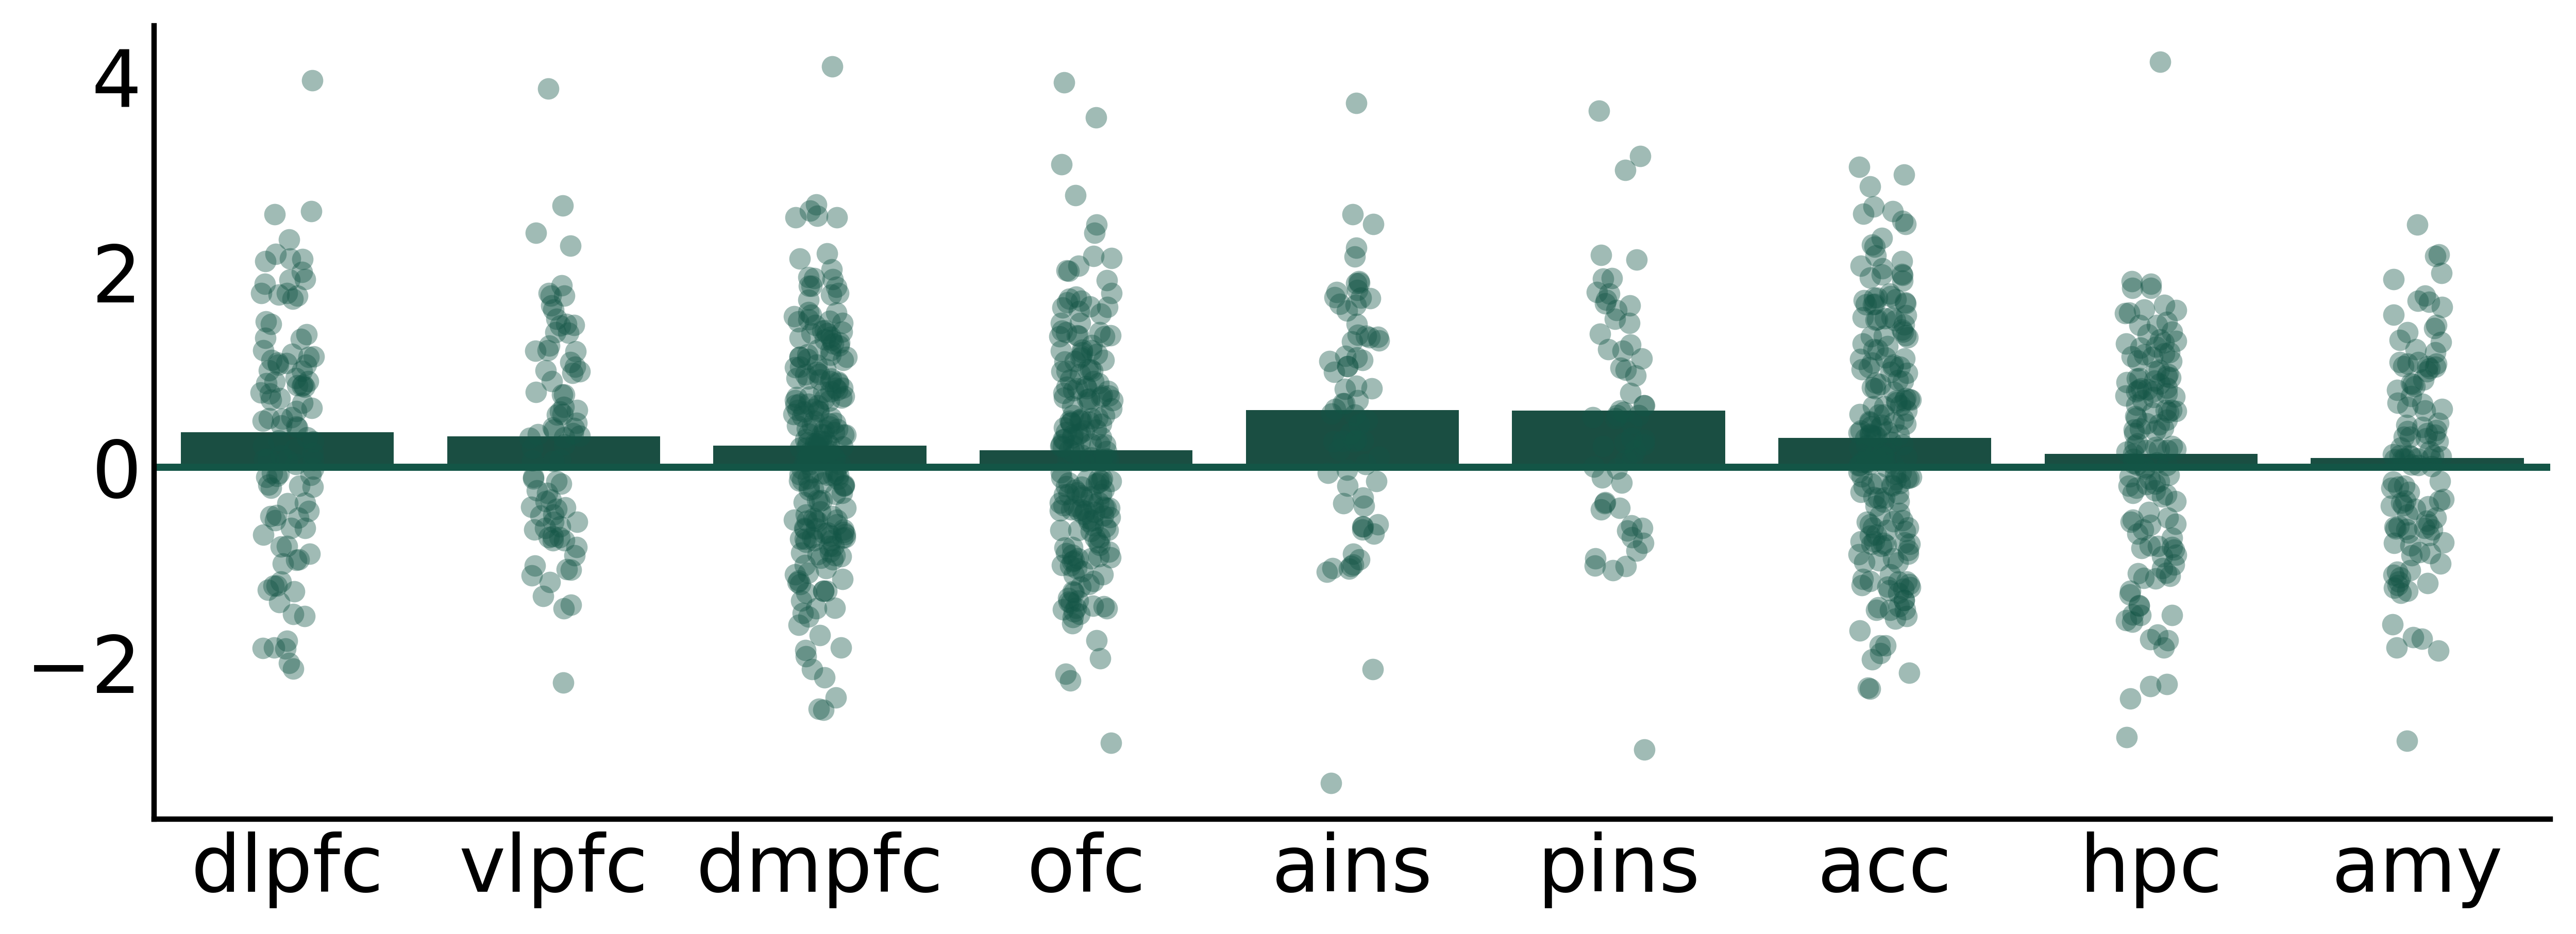

In [53]:
plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,4),color='#135546')
# green '#135546'


In [54]:
results.groupby('roi').agg('mean')['Z_Score_decisionCPE'][bar_order]

roi
dlpfc    0.360810
vlpfc    0.317906
dmpfc    0.222372
ofc      0.177244
ains     0.588194
pins     0.579048
acc      0.300715
hpc      0.139100
amy      0.093927
Name: Z_Score_decisionCPE, dtype: float64

In [55]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.030883,-0.048833,0.024836,0.030278,-0.002225,-0.000975,...,0.021605,0.022110,2.017426,-2.017426,1.155243,1.344197,0.043651,0.043651,0.247991,0.178885
1,MS002_lacas2-lacas3,MS002,acc,14,-0.010171,0.017089,0.019667,0.041767,0.001676,-0.000036,...,0.026959,0.025136,-0.610713,0.610713,0.724511,1.674859,0.541390,0.541390,0.468752,0.093962
2,MS002_lacas3-lacas4,MS002,acc,14,0.010854,-0.016153,0.012513,0.045390,-0.000735,0.000600,...,0.023052,0.023218,0.638730,-0.638730,0.530250,1.944106,0.522999,0.522999,0.595939,0.051883
3,MS002_lacas4-lacas5,MS002,acc,14,0.002168,-0.016207,-0.007460,0.041141,-0.009189,0.000210,...,0.021055,0.020767,0.719456,-0.719456,-0.334509,1.970064,0.471860,0.471860,0.737996,0.048831
4,MS002_lacas5-lacas6,MS002,acc,14,-0.008841,0.017567,-0.006853,-0.003911,0.002637,0.000975,...,0.022006,0.021010,-0.686458,0.686458,-0.319261,-0.188495,0.492424,0.492424,0.749528,0.850489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1862,DA039_rpins1-rpins2,DA039,pins,22,0.006150,0.000627,-0.006567,0.023253,0.006042,0.000910,...,0.025518,0.025425,0.010886,-0.010886,-0.223642,0.939816,0.991314,0.991314,0.823036,0.347312
1863,DA039_rpins2-rpins3,DA039,pins,22,0.012924,0.037311,0.002998,0.014782,0.027304,-0.000200,...,0.027034,0.027809,-1.392224,1.392224,0.111049,0.510100,0.163855,0.163855,0.911577,0.609982
1864,DA039_rpins3-rpins4,DA039,pins,22,-0.005030,-0.032606,-0.054730,0.044405,-0.017260,-0.000702,...,0.028718,0.028970,1.081434,-1.081434,-1.943669,1.479278,0.279504,0.279504,0.051935,0.139066
1877,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.123066,0.017559,0.011615,0.056642,-0.116101,-0.000610,...,0.047269,0.046641,-0.393639,0.393639,0.226441,1.191610,0.693848,0.693848,0.820858,0.233414


In [56]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)

In [57]:
agg_single_results = single_elec_res.groupby('roi').agg('mean')[['Z_Score_decisionCPE']].copy()

agg_single_results


,Z_Score_decisionCPE
roi,
acc,0.300715
ains,0.588194
amy,0.093927
dlpfc,0.360810
dmpfc,0.222372
hpc,0.139100
ofc,0.177244
pins,0.579048
vlpfc,0.317906


In [58]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_decisionCPE'] = agg_single_results.Z_Score_decisionCPE
single_rho_data

,rho,rho_p,Z_Score_decisionCPE
roi,,,
acc,-0.129426,0.0728,0.300715
dmpfc,-0.023646,0.7297,0.222372
amy,-0.012987,0.8914,0.093927
ains,-0.277623,0.0191,0.588194
vlpfc,-0.285631,0.0093,0.317906
hpc,-0.100293,0.2471,0.139100
ofc,-0.211044,0.0026,0.177244
pins,0.053250,0.6862,0.579048
dlpfc,-0.214837,0.0263,0.360810


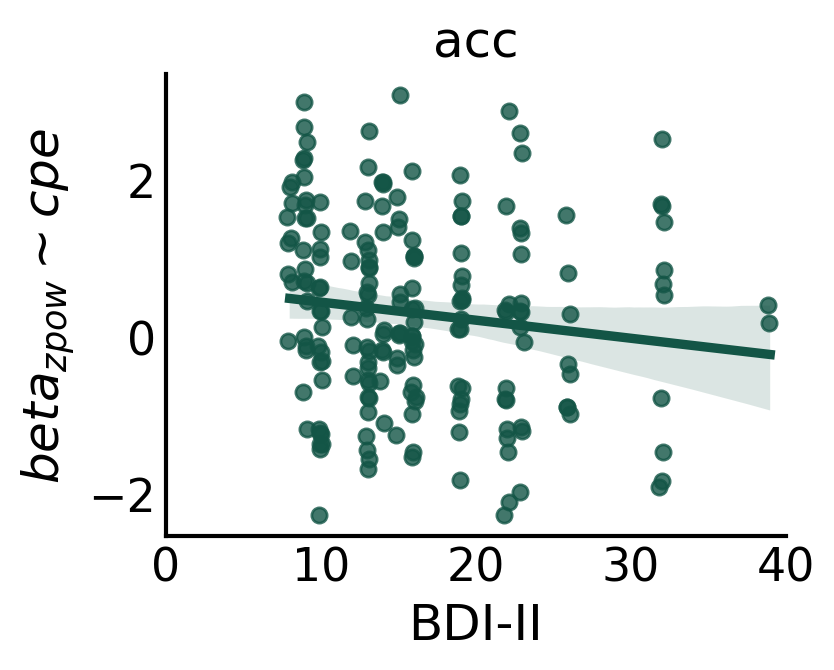

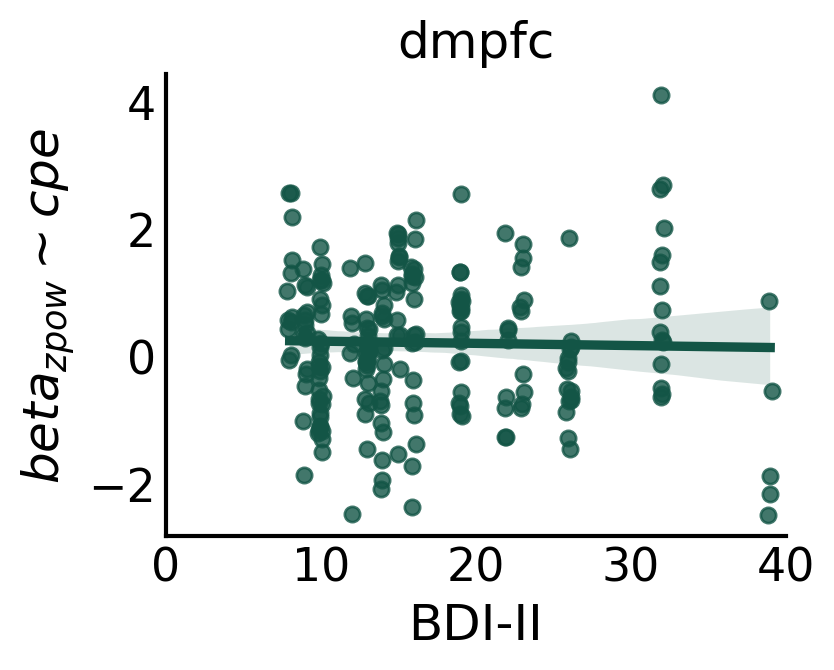

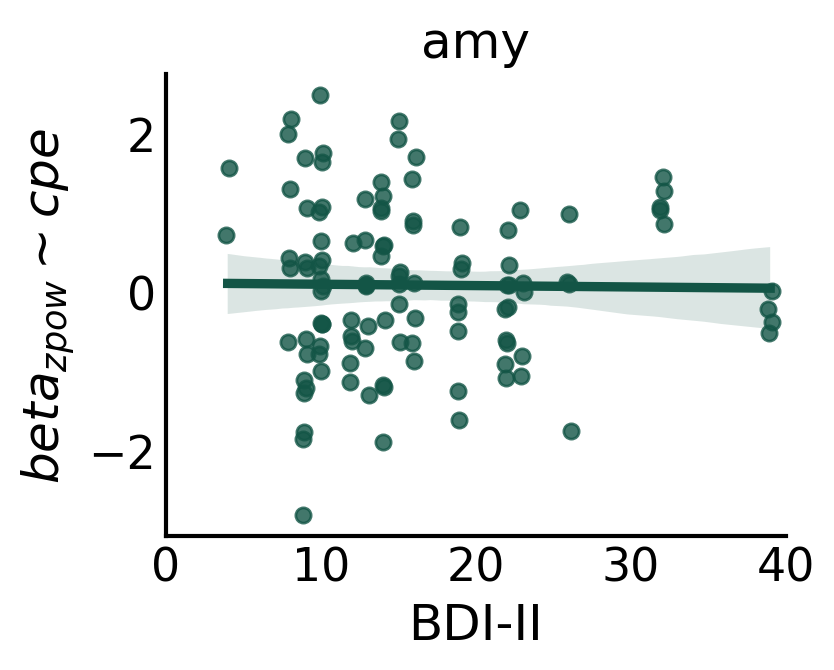

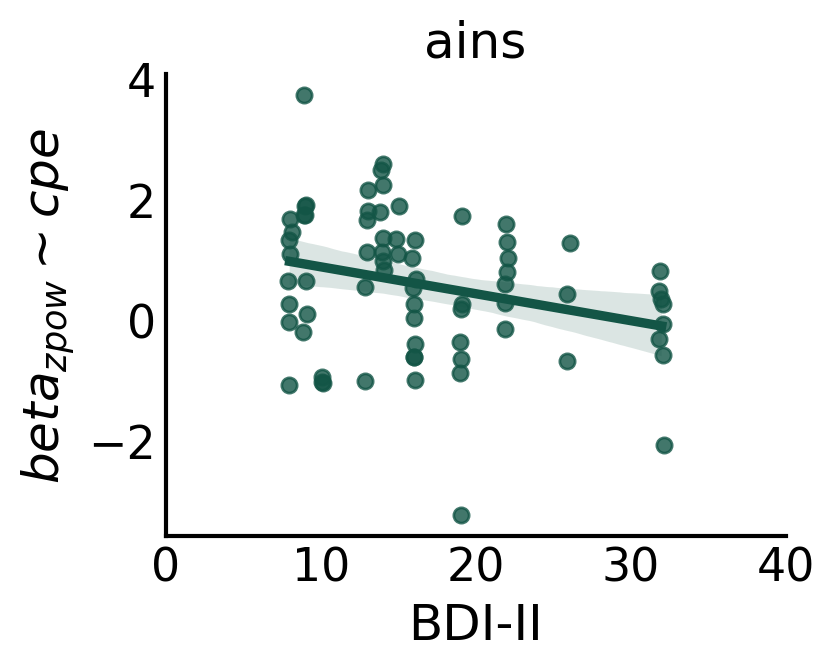

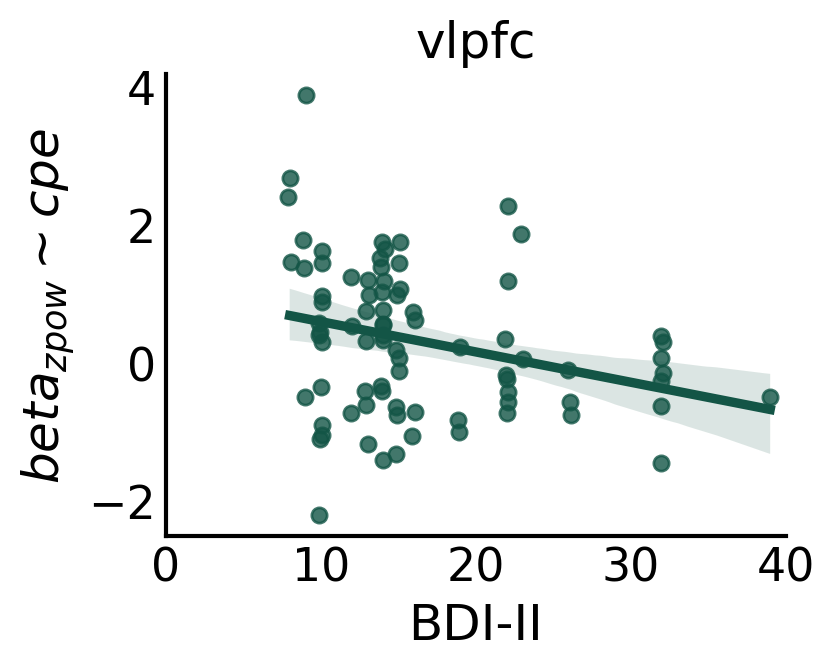

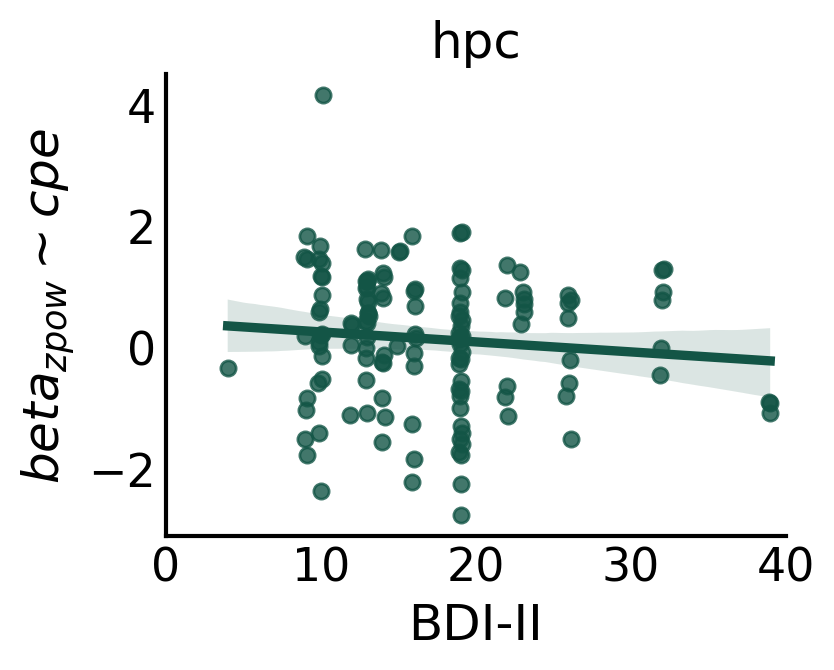

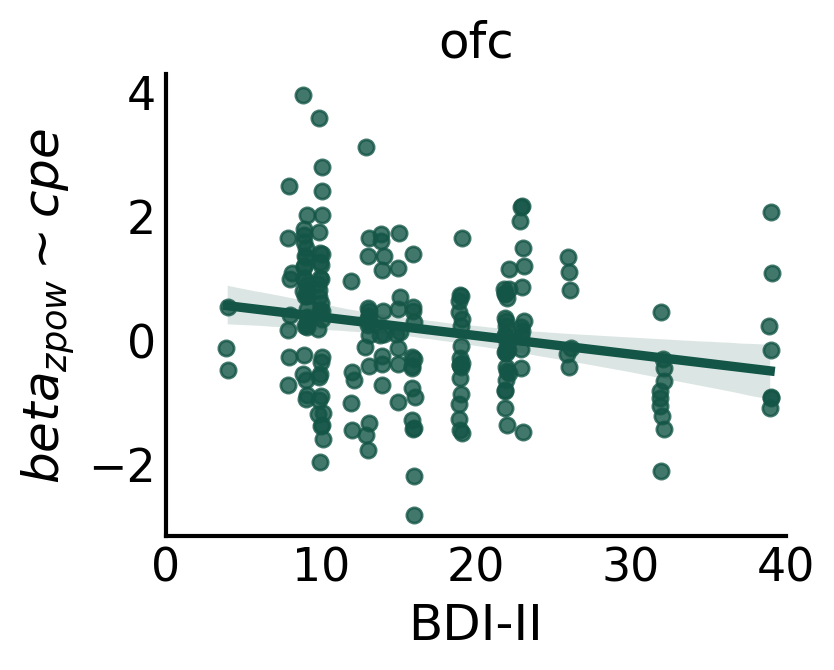

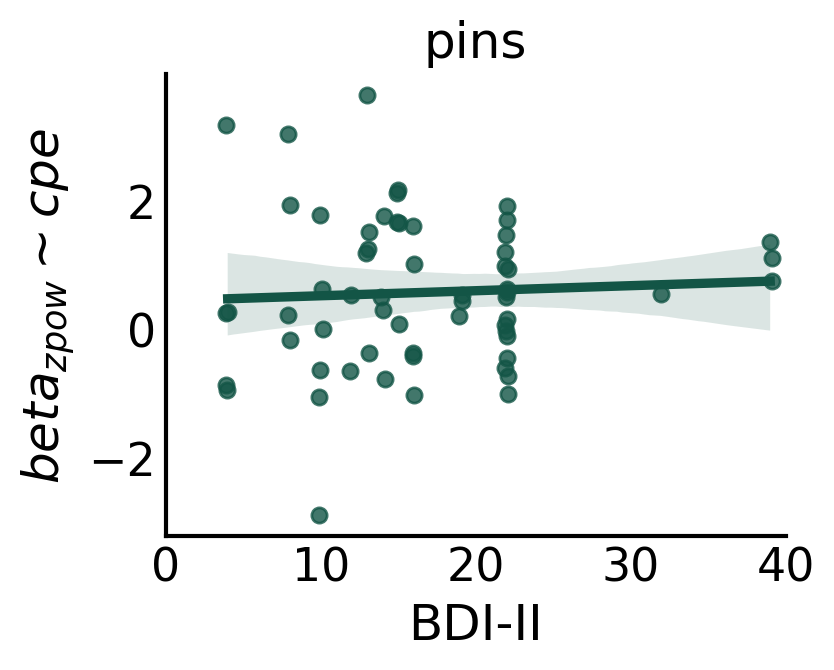

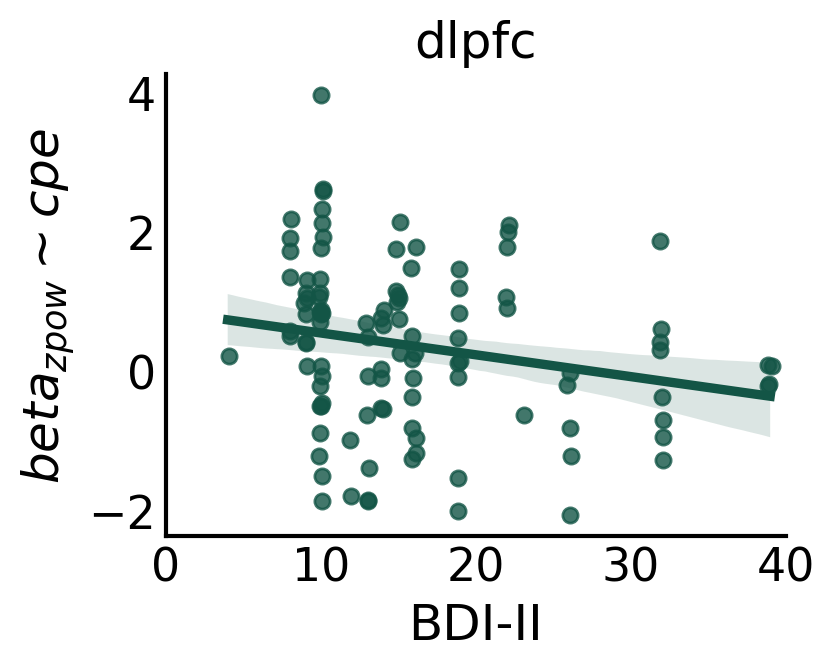

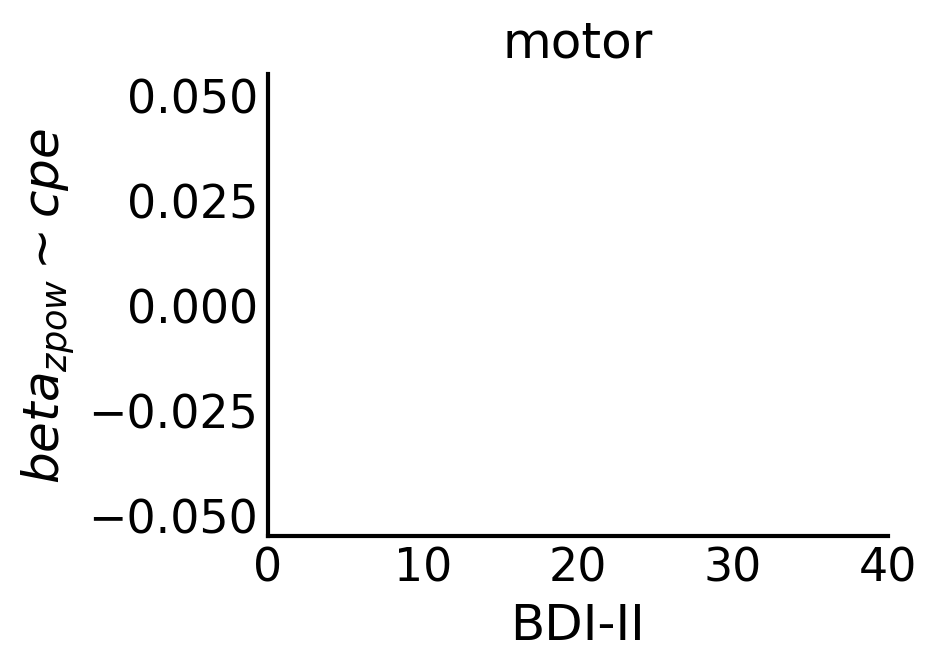

In [59]:
band = 'beta'

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = '#135546',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()


# Mixed effects models

In [60]:
beta_reg_df = beta_df.copy()
beta_reg_df = beta_reg_df[beta_reg_df.roi.isin(bar_order)]
beta_reg_df


,Unnamed: 0,subj_id,bdi,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,...,SafeBet,GambleChoice,GambleChoice_t1,TrialEV,Profit,TotalProfit,RPE,decisionCPE,decisionRegret,decisionRelief
0,0,MS002,14,lacas1-lacas2,MS002_lacas1-lacas2,0,20.743342,beta,-0.123971,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
1,1,MS002,14,lacas2-lacas3,MS002_lacas2-lacas3,0,20.743342,beta,-0.186139,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
2,2,MS002,14,lacas3-lacas4,MS002_lacas3-lacas4,0,20.743342,beta,-0.235353,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
3,3,MS002,14,lacas4-lacas5,MS002_lacas4-lacas5,0,20.743342,beta,-0.086471,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
4,4,MS002,14,lacas5-lacas6,MS002_lacas5-lacas6,0,20.743342,beta,-0.145393,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258455,258455,DA039,22,rpins1-rpins2,DA039_rpins1-rpins2,148,20.743342,beta,0.219118,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258456,258456,DA039,22,rpins2-rpins3,DA039_rpins2-rpins3,148,20.743342,beta,0.080566,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258457,258457,DA039,22,rpins3-rpins4,DA039_rpins3-rpins4,148,20.743342,beta,0.204231,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258470,258470,DA039,22,rsgcc6-rsgcc7,DA039_rsgcc6-rsgcc7,148,20.743342,beta,-0.199545,vlpfc,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244


In [61]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'decisionCPE','roi','hemi','bdi','bdi:decisionCPE']
rand_vars    = ['GambleChoice','TotalProfit', 'decisionCPE']


In [62]:
roi_fit_dict = {f'{roi}':fit_mixed_model(beta_reg_df[beta_reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in beta_reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],beta_reg_df[beta_reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [69]:
roi_fit_results['band'] = 'beta'
# roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=25.15983042995267, pvalue=1.0790652673721144e-62, df=192),
 'dmpfc': TtestResult(statistic=11.214186629091538, pvalue=2.8022002371023047e-23, df=215),
 'amy': TtestResult(statistic=-1.5512443809593819, pvalue=0.12366434870239791, df=112),
 'ains': TtestResult(statistic=38.158698175761174, pvalue=1.3832802599846608e-48, df=70),
 'vlpfc': TtestResult(statistic=28.088613889770517, pvalue=1.6246464794522154e-43, df=81),
 'hpc': TtestResult(statistic=8.378290826945442, pvalue=6.40380913844168e-14, df=134),
 'ofc': TtestResult(statistic=42.04920276078307, pvalue=1.477222334268924e-101, df=201),
 'pins': TtestResult(statistic=8.22890680049308, pvalue=2.2462572082490342e-11, df=59),
 'dlpfc': TtestResult(statistic=15.199177593043716, pvalue=2.209239020246355e-28, df=106)}

In [63]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]
fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],hemi[T.r],TotalProfit,decisionCPE,bdi,bdi:decisionCPE,roi,cpe_pval,bdi_pval,cpe_bdi_pval
0,0.007723,-0.013800,0.004556,0.001196,0.017020,-0.000858,-0.000608,acc,0.0043,0.0012,0.0738
1,-0.031915,-0.008017,0.006599,0.010465,0.009212,-0.000409,-0.000119,dmpfc,0.1675,0.5536,0.7483
2,-0.077182,0.008994,0.000278,0.011262,-0.001063,-0.000840,0.000196,amy,0.9330,0.6980,0.7955
3,0.061131,-0.016248,-0.021374,0.009931,0.061766,-0.001848,-0.002251,ains,0.0000,0.0190,0.0053
4,0.003940,-0.013510,-0.010860,0.005658,0.040533,-0.001722,-0.001662,vlpfc,0.0001,0.0383,0.0046
5,-0.188515,0.007712,-0.002708,-0.005739,0.012162,0.003992,-0.000637,hpc,0.3305,0.0705,0.3608
6,0.021404,0.000446,-0.049642,0.004967,0.026380,-0.002604,-0.001190,ofc,0.0000,0.0158,0.0003
7,-0.056432,0.003965,-0.013023,0.002661,0.022169,0.000255,-0.000155,pins,0.0716,0.9036,0.8169
8,-0.030595,-0.010656,0.011508,0.012675,0.026423,-0.001045,-0.000915,dlpfc,0.0013,0.0946,0.0428


In [64]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha

0.005555555555555556

In [65]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois

['acc', 'ains', 'vlpfc', 'ofc', 'dlpfc']

In [66]:
sig_cpe_bdi_rois = fe_results.roi[fe_results.cpe_bdi_pval <= bonferr_alpha].tolist()
sig_cpe_bdi_rois

['ains', 'vlpfc', 'ofc']

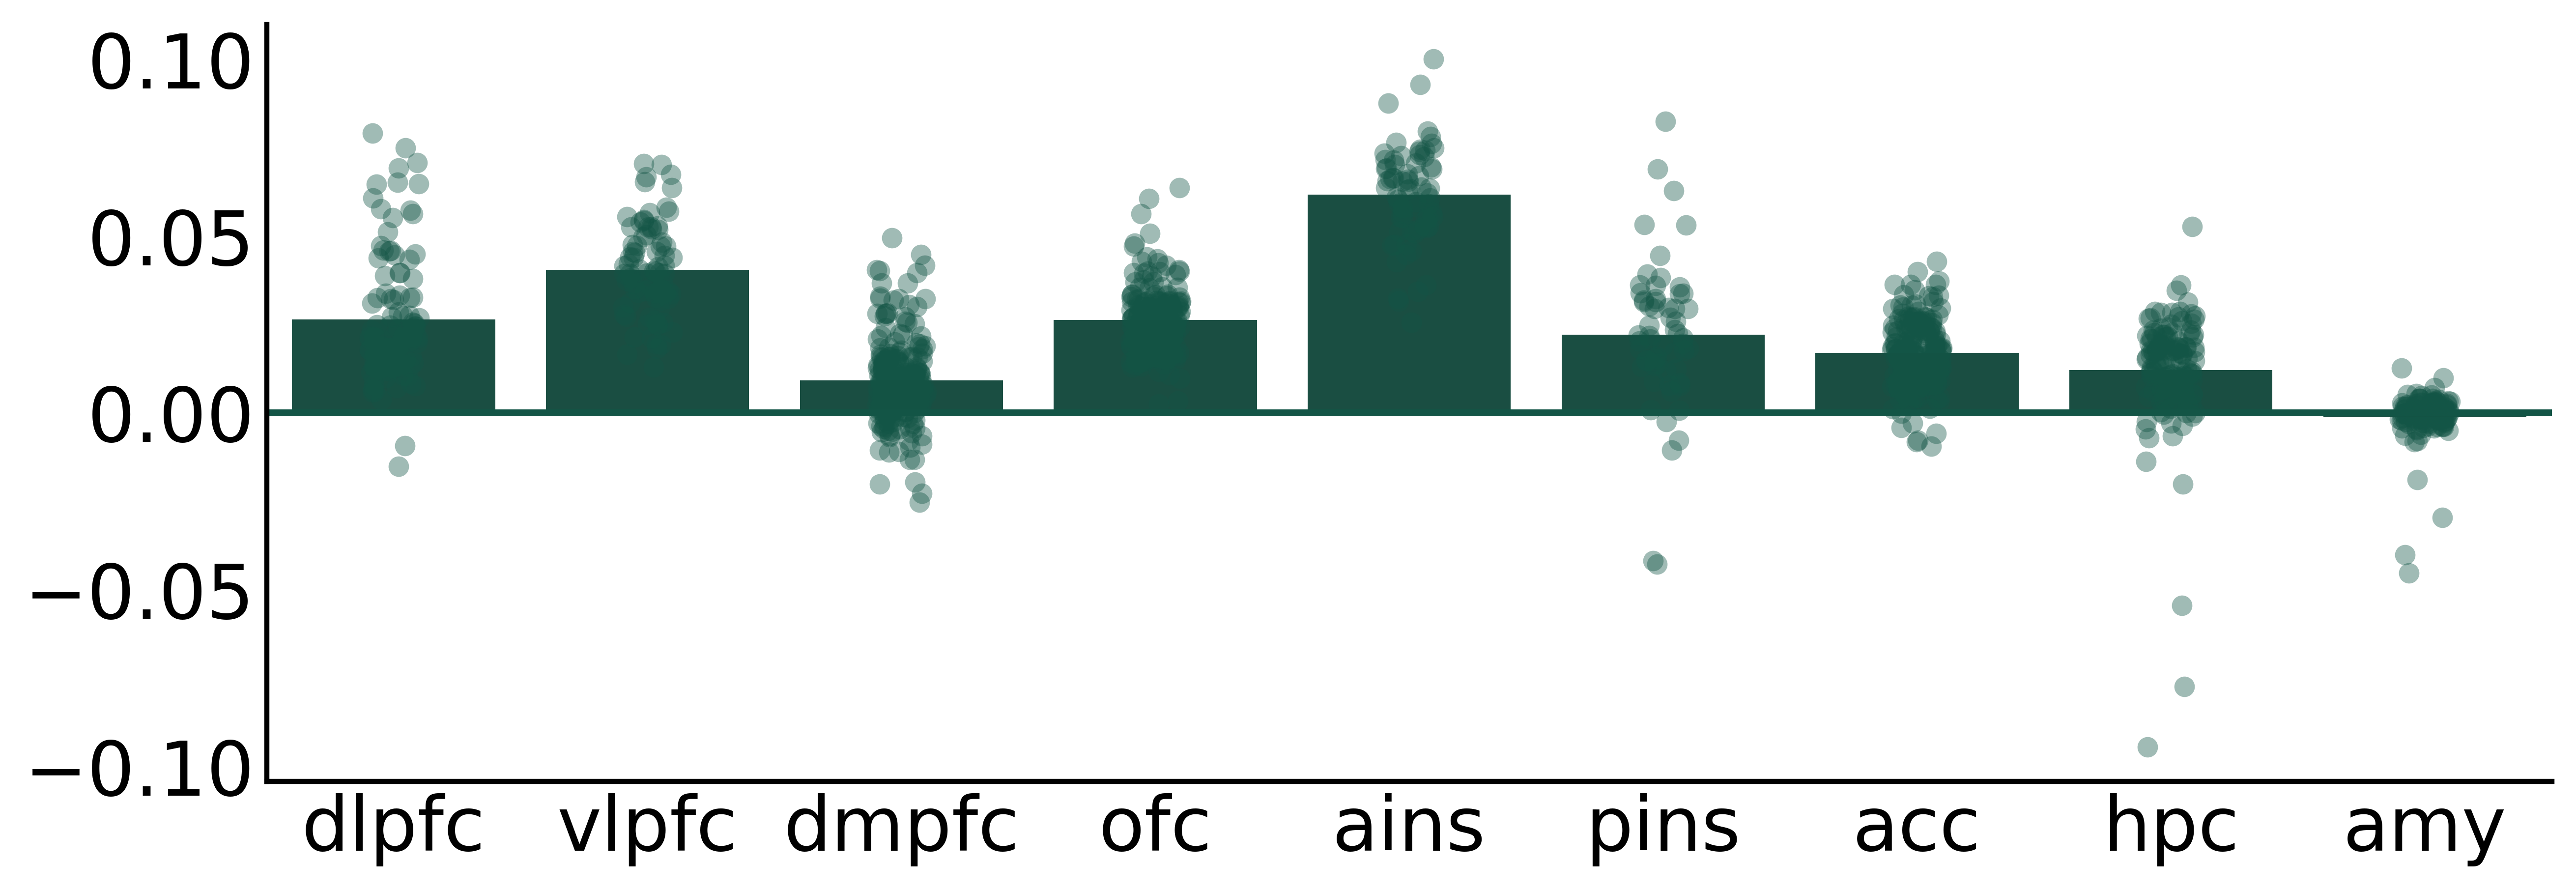

In [67]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=bar_order,figsize=(12,4),color='#135546')


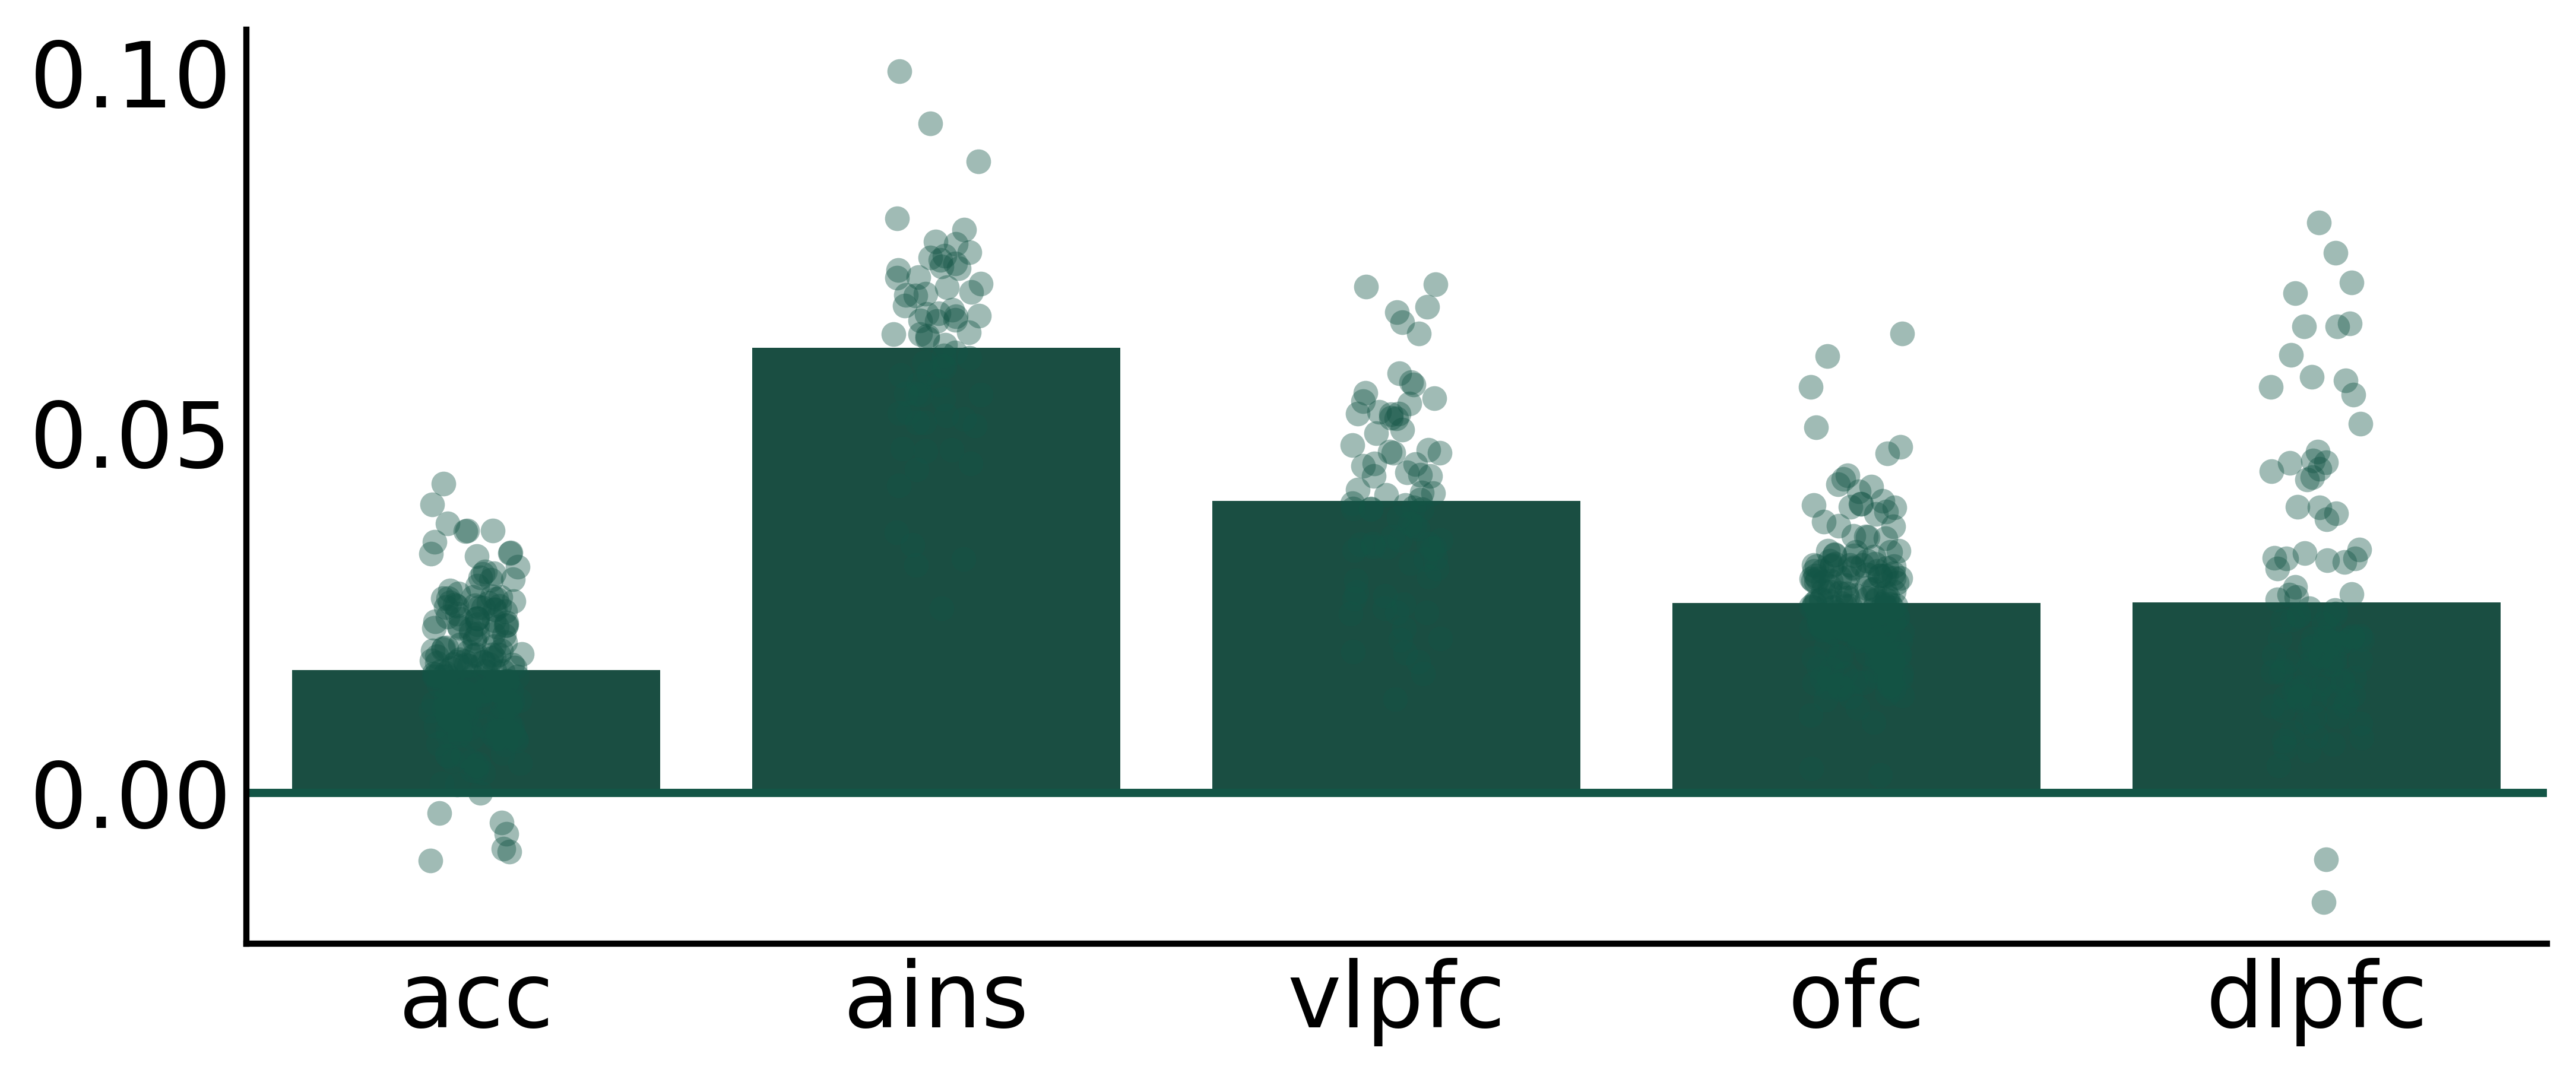

In [68]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=sig_rois,color='#135546')


# # plot ROI beta distribution
# sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# plt.title(f'ACC n={n}')
# sns.despine()


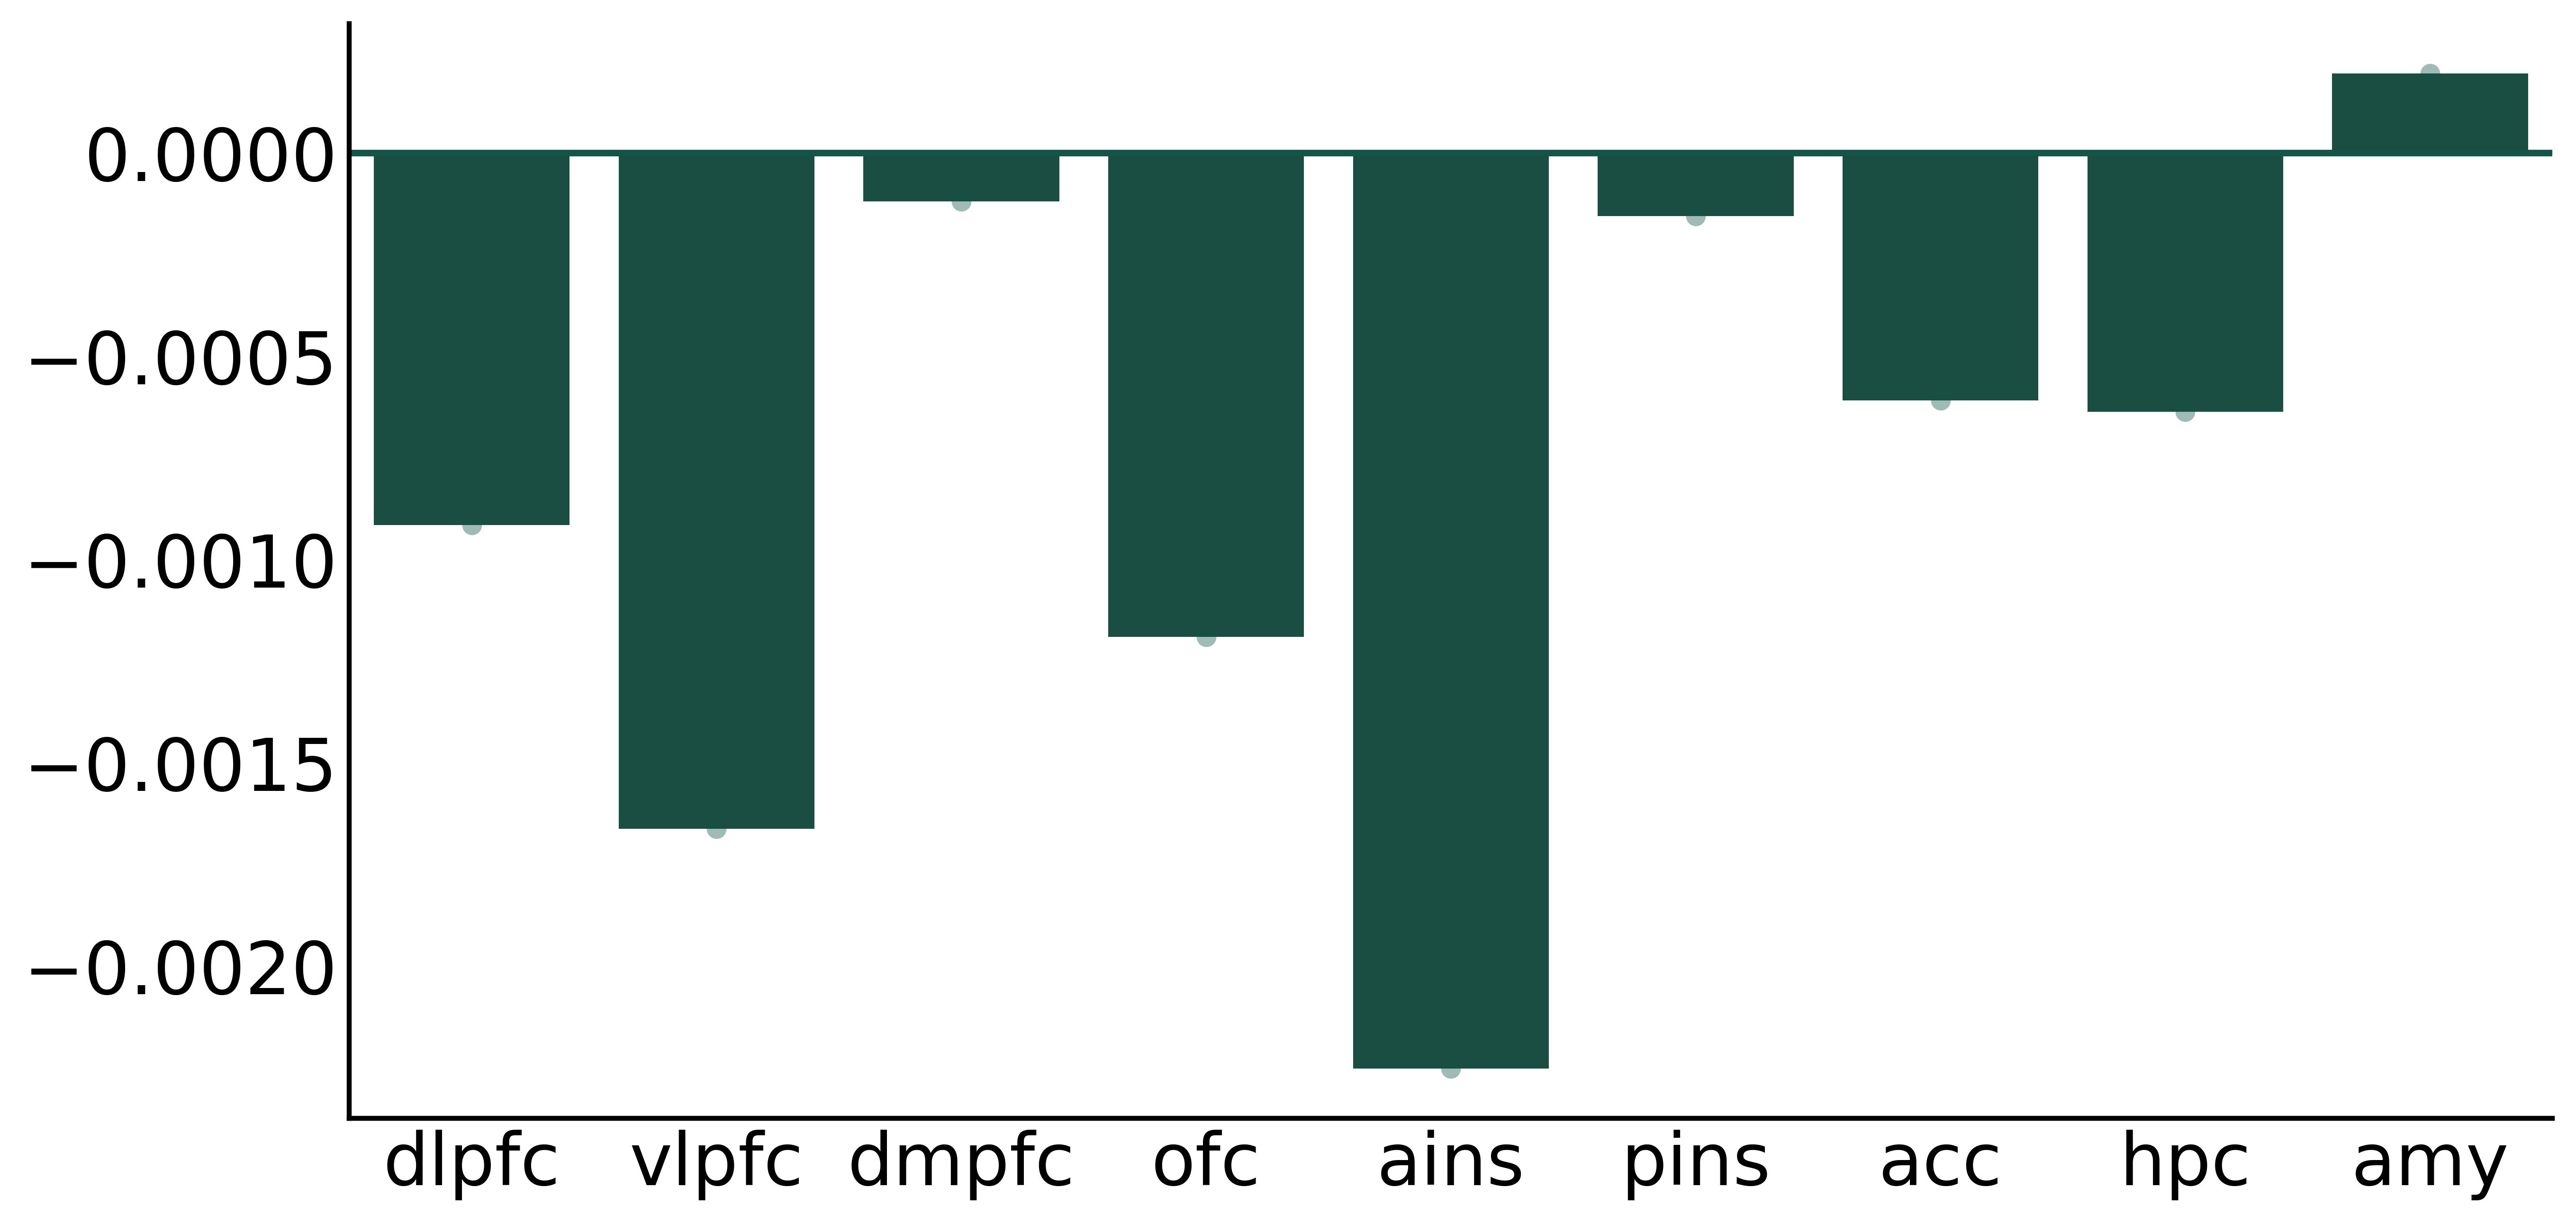

In [70]:
plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#135546')
# add to slides 
